In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
import polars as pl
import polars.selectors as cs
from copairs.map import average_precision, mean_average_precision
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from Data_filtering.features_engineering import features_drop_corr_gpu
import Data_filtering.plot_distribution_table as pdt

# 1) Get features and Scale

In [2]:
metadata_df = pd.read_csv("target2_eq_moa2_metadata", index_col="ID") 
features_df = pd.read_csv("target2_eq_moa2_features", index_col="ID") 
nan_col = features_df.columns[features_df.isna().sum(axis=0) > 0]
nan_col, len(nan_col)
inf_col = features_df.columns[(features_df == np.inf).sum(axis=0) > 0]
inf_col, len(inf_col)
features_df = features_df[features_df.columns[(features_df.isna().sum(axis=0) == 0) & 
                                            ((features_df == np.inf).sum(axis=0) == 0) & 
                                            (features_df.std() != 0)]]
metadata_df = metadata_df.assign(moa_id=LabelEncoder().fit_transform(metadata_df["moa"]))
features_df = features_df.sort_index().reset_index(drop=True)
metadata_df = metadata_df.sort_index().reset_index()
metadata_df = metadata_df.assign(
    trt_dmso=metadata_df["pert_iname"].where(metadata_df["pert_iname"] == "DMSO", other="trt"))
metadata_df["trt_index"] = metadata_df.index
metadata_df.loc[metadata_df["pert_iname"] == "DMSO", "trt_index"] = -1

In [3]:
features_df = features_drop_corr_gpu(threshold=0.95).fit_transform(features_df)
dmso_scaler = RobustScaler().fit(features_df[metadata_df["trt_dmso"] == "DMSO"])
features_df = dmso_scaler.transform(features_df)

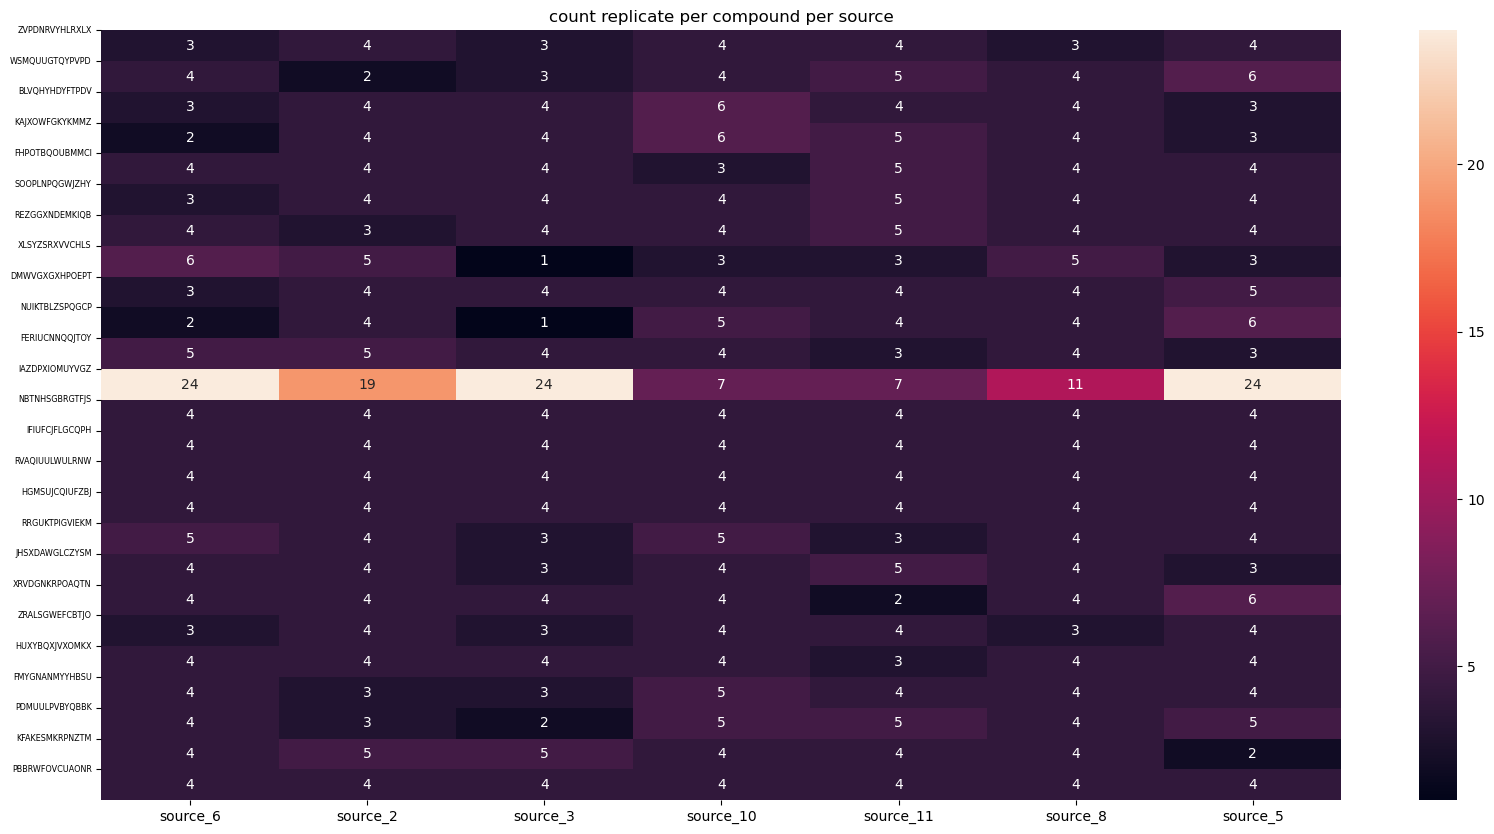

In [4]:
pdt.replicate_per_source_per_comp(pl.DataFrame(metadata_df))

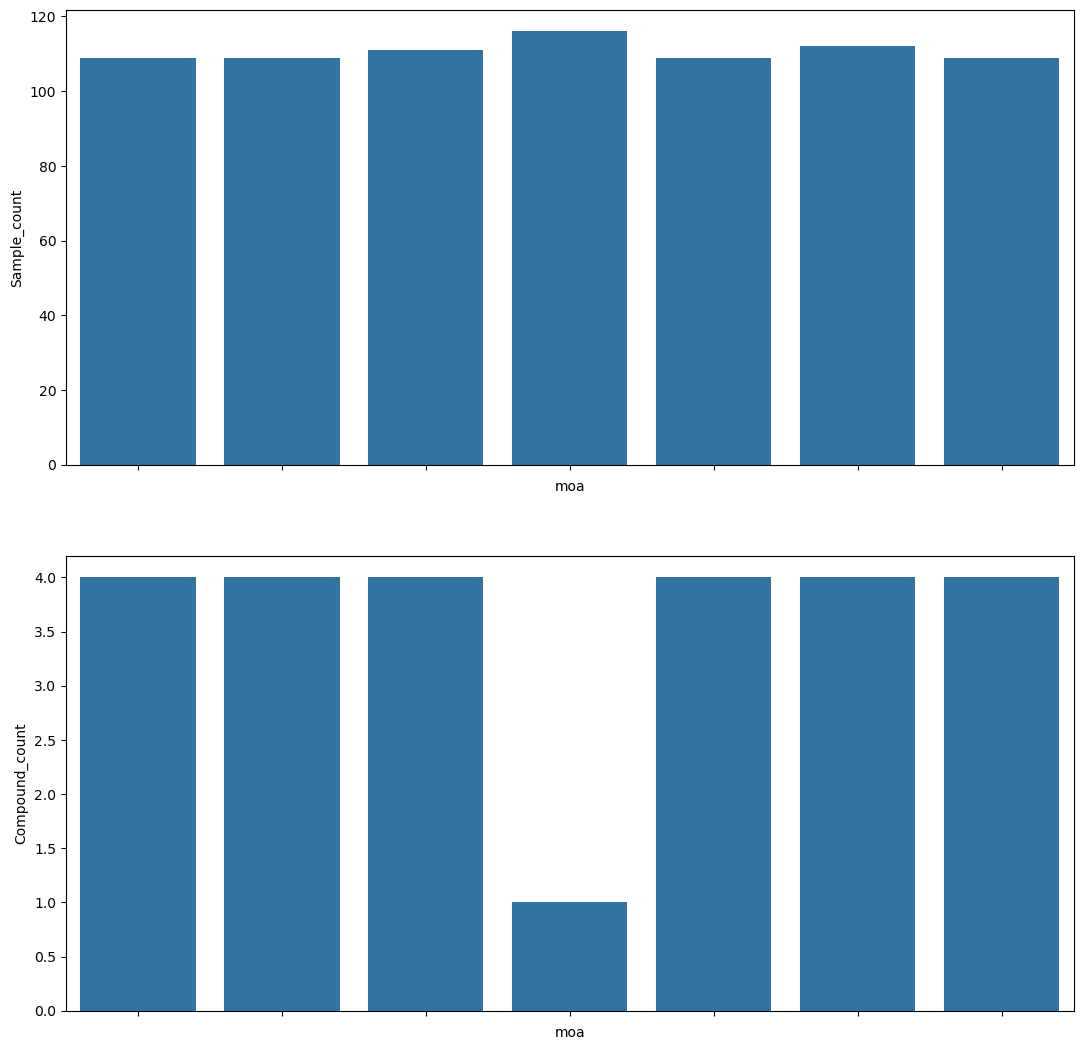

In [5]:
pdt.moa_distribution(pl.DataFrame(metadata_df))

# 2) UMAP

In [6]:
mask = np.ones(len(metadata_df["Micro_id"])).astype(bool)# == 2
model_umap = umap.UMAP()
features_df_umap = model_umap.fit_transform(features_df[mask])

Text(0.5, 1.0, 'UMAP - InChIKey from moa_id: 0')

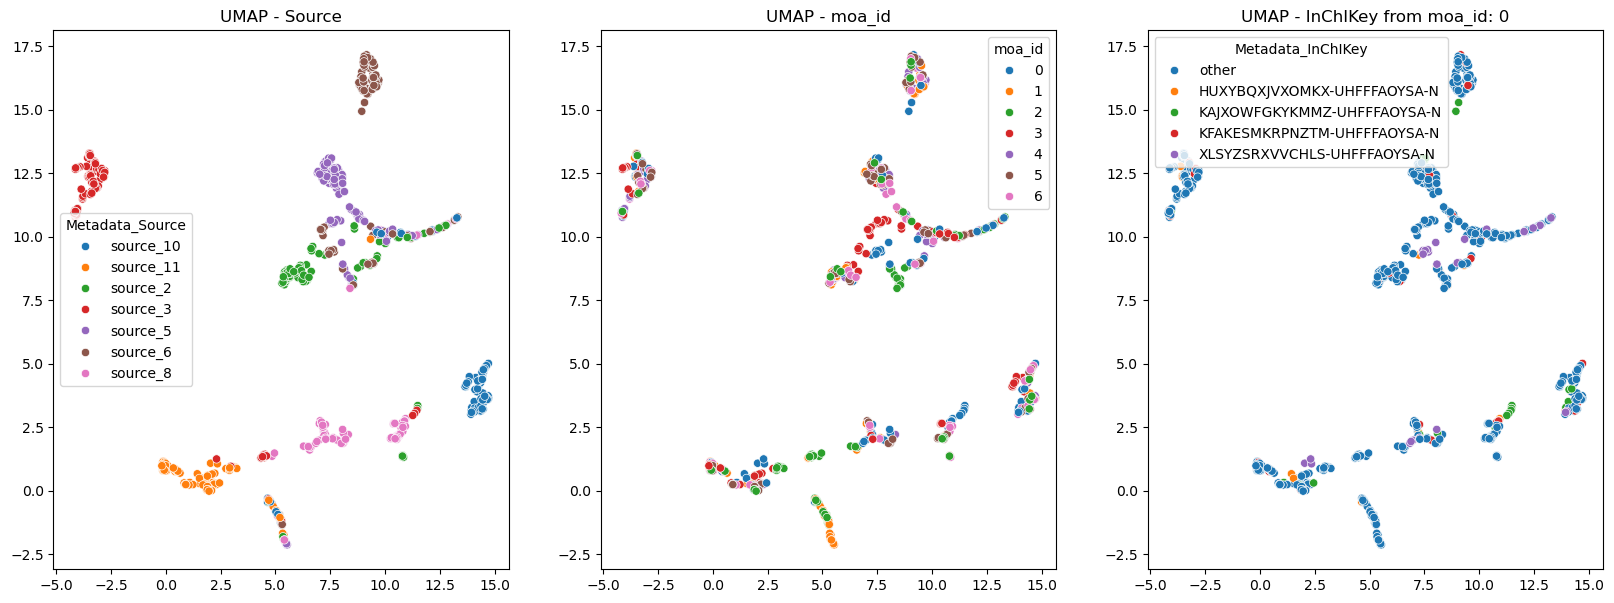

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes = axes.flatten()


sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df[mask]["Metadata_Source"],
                ax=axes[0],
                palette="tab10")
axes[0].set_title("UMAP - Source")
#axes[0].get_legend().remove()

sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df[mask]["moa_id"],
                ax=axes[1], 
                palette="tab10")
axes[1].set_title("UMAP - moa_id")

sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df[mask]["Metadata_InChIKey"].where(metadata_df[mask]["moa_id"]==0, other="other"),
                #alpha=0.2,
                ax=axes[2], 
                palette="tab10")
axes[2].set_title("UMAP - InChIKey from moa_id: 0")

# 3) Check Phenotypic activity
We are going to check phenotypic activity at the replicate level within a same inchikey compare to dmso which come from the same plate as the replicate selected for the positive pair (to restrict a bit negative pair and have something more significative)

In [8]:
list_metadata_df = [metadata_df[(((metadata_df["trt_dmso"] == "DMSO") & 
                              (metadata_df["Metadata_Plate"]
                               .isin(pl.DataFrame(metadata_df)
                                     .filter(pl.col("Metadata_InChIKey") == inchi)
                                     .select(pl.col("Metadata_Plate"))
                                     .unique()
                                     .to_series().to_list()))) | 
                              (metadata_df["Metadata_InChIKey"] == inchi))]
for inchi in metadata_df[(metadata_df["trt_dmso"] != "DMSO")]["Metadata_InChIKey"].drop_duplicates().to_list()]

In [9]:
res_mask = np.zeros(len(metadata_df)).astype(bool)
for index in range(len(list_metadata_df)):
    pos_sameby = ["Metadata_InChIKey"]#, "Metadata_Source"]  # We want to match perturbations
    pos_diffby = ["trt_index"]
    neg_sameby = []#["Metadata_Batch"]
    neg_diffby = ["trt_dmso"]
    batch_size = 20000
    
    
    result = average_precision(
        list_metadata_df[index],
        features_df[list_metadata_df[index]["ID"]],#.to_numpy(),
        pos_sameby,
        pos_diffby,
        neg_sameby,
        neg_diffby,
        batch_size,
    )
    
    result = result[result["trt_dmso"] != "DMSO"]
    mAP = mean_average_precision(result, ["ID"],
                                 null_size=10000000, threshold=0.05, seed=42)
    res_mask |= (metadata_df["ID"].isin(mAP[mAP["below_corrected_p"]]["ID"]) | (metadata_df["trt_dmso"] == "DMSO"))
metadata_df_active = metadata_df[res_mask]
features_df_active = features_df[res_mask]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
# Now we filter out any compound which doesn't have enough replicate
# As well as any moa which doesn't have enough compound
mask_active_keep = metadata_df_active["Metadata_InChIKey"].isin(
(pl.DataFrame(metadata_df_active)
 .group_by(["moa_id","Metadata_InChIKey"])
 .agg(pl.col("Metadata_InChIKey").count().alias("rep_count"),
      pl.col("trt_dmso").unique()).explode("trt_dmso")
 .filter(pl.col("rep_count") > 10)
 .with_columns(
     pl.col("Metadata_InChIKey").n_unique().over("moa_id").alias("pert_per_moa"))
 .filter((pl.col("trt_dmso") == "DMSO") | 
         (pl.col("pert_per_moa") > 2))
 .select("Metadata_InChIKey")
 .to_series().to_list()))

metadata_df_active_keep = metadata_df_active[mask_active_keep]

Now let's filter out the dmso that we don't need anymore

In [11]:
print("replicate per moa:", pl.DataFrame(metadata_df_active_keep).group_by("moa_id").count())
print("trt replicate count vs plate", (pl.DataFrame(metadata_df_active_keep)
 .filter(pl.col("trt_dmso") == "trt")).select(pl.col(["ID", "Metadata_Plate"]).n_unique()))
print("dmso replicate count vs plate", (pl.DataFrame(metadata_df_active_keep)
 .filter(pl.col("trt_dmso") == "DMSO")).select(pl.col(["ID", "Metadata_Plate"]).n_unique()))

replicate per moa: shape: (4, 2)
┌────────┬───────┐
│ moa_id ┆ count │
│ ---    ┆ ---   │
│ i64    ┆ u32   │
╞════════╪═══════╡
│ 3      ┆ 66    │
│ 4      ┆ 116   │
│ 2      ┆ 72    │
│ 0      ┆ 66    │
└────────┴───────┘
trt replicate count vs plate shape: (1, 2)
┌─────┬────────────────┐
│ ID  ┆ Metadata_Plate │
│ --- ┆ ---            │
│ u32 ┆ u32            │
╞═════╪════════════════╡
│ 204 ┆ 89             │
└─────┴────────────────┘
dmso replicate count vs plate shape: (1, 2)
┌─────┬────────────────┐
│ ID  ┆ Metadata_Plate │
│ --- ┆ ---            │
│ u32 ┆ u32            │
╞═════╪════════════════╡
│ 116 ┆ 116            │
└─────┴────────────────┘


Based on this filtering based on phenotypic activity, we need now to downsample dmso. Since there is exactly one dmso per plate, let's remove the plate that are not present anymore. 89 is relatively close enough from the other moa so let's not remove any dmso.

In [12]:
dmso_mask_id = (pl.DataFrame(metadata_df_active_keep)
                 .filter((pl.col("trt_dmso") == "DMSO") & 
                         (pl.col("Metadata_Plate").is_in(
                             (pl.DataFrame(metadata_df_active_keep)
                              .filter(pl.col("trt_dmso") == "trt")).select(pl.col("Metadata_Plate"))
                             .to_series().to_list())))).to_series().to_list()
                 # .sort(by=["Metadata_Source", "Metadata_Batch", "Metadata_Plate"])
                 # .sample(68, seed=42)).select(pl.col("ID")).to_series().to_list()
dmso_mask = (metadata_df_active_keep["ID"].isin(dmso_mask_id)) | (metadata_df_active_keep["trt_dmso"] == "trt")
metadata_df_active_keep_dmso = metadata_df_active_keep[dmso_mask]

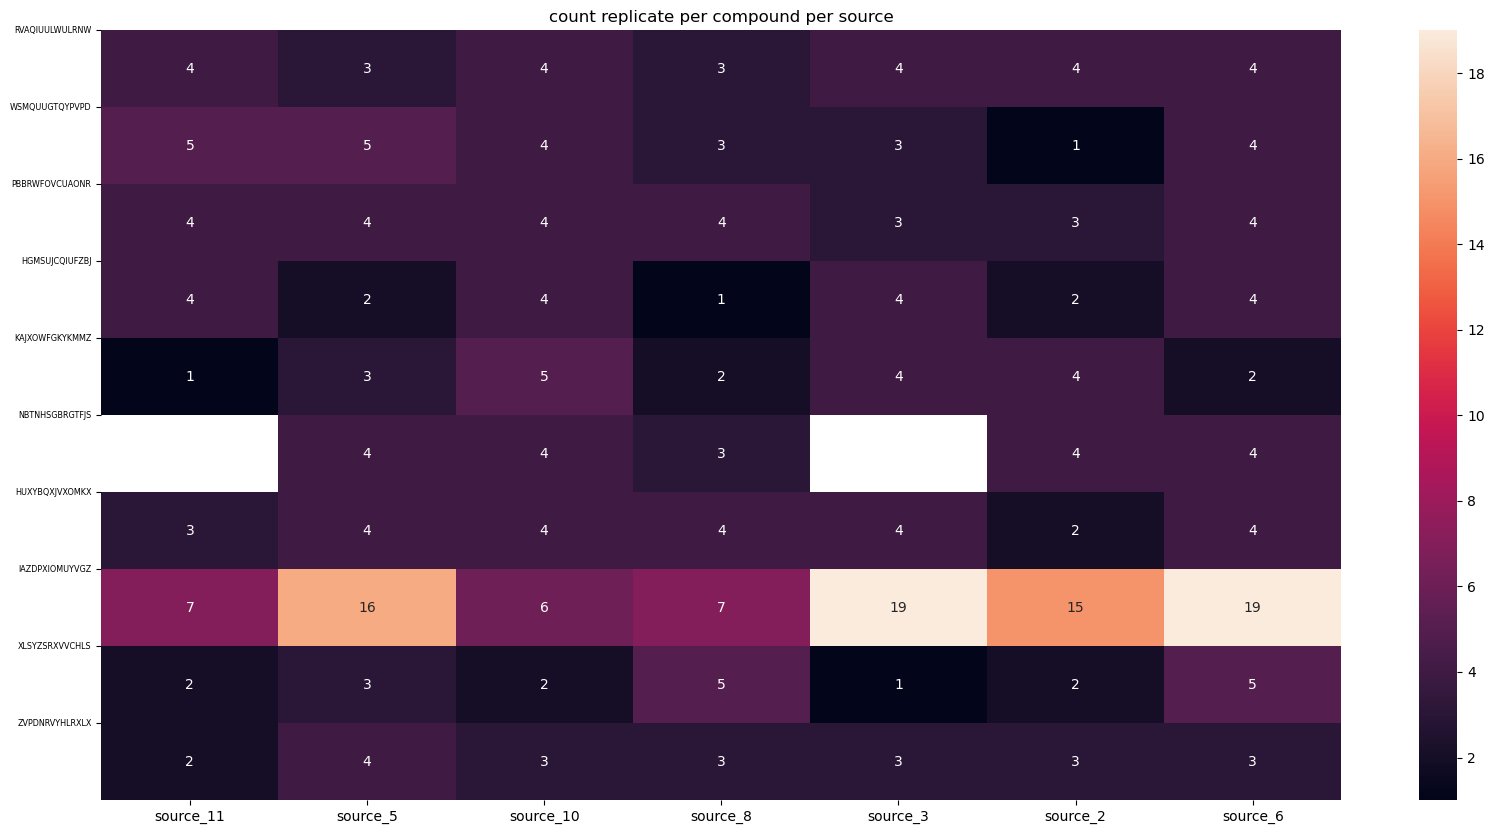

In [13]:
pdt.replicate_per_source_per_comp(pl.DataFrame(metadata_df_active_keep_dmso))

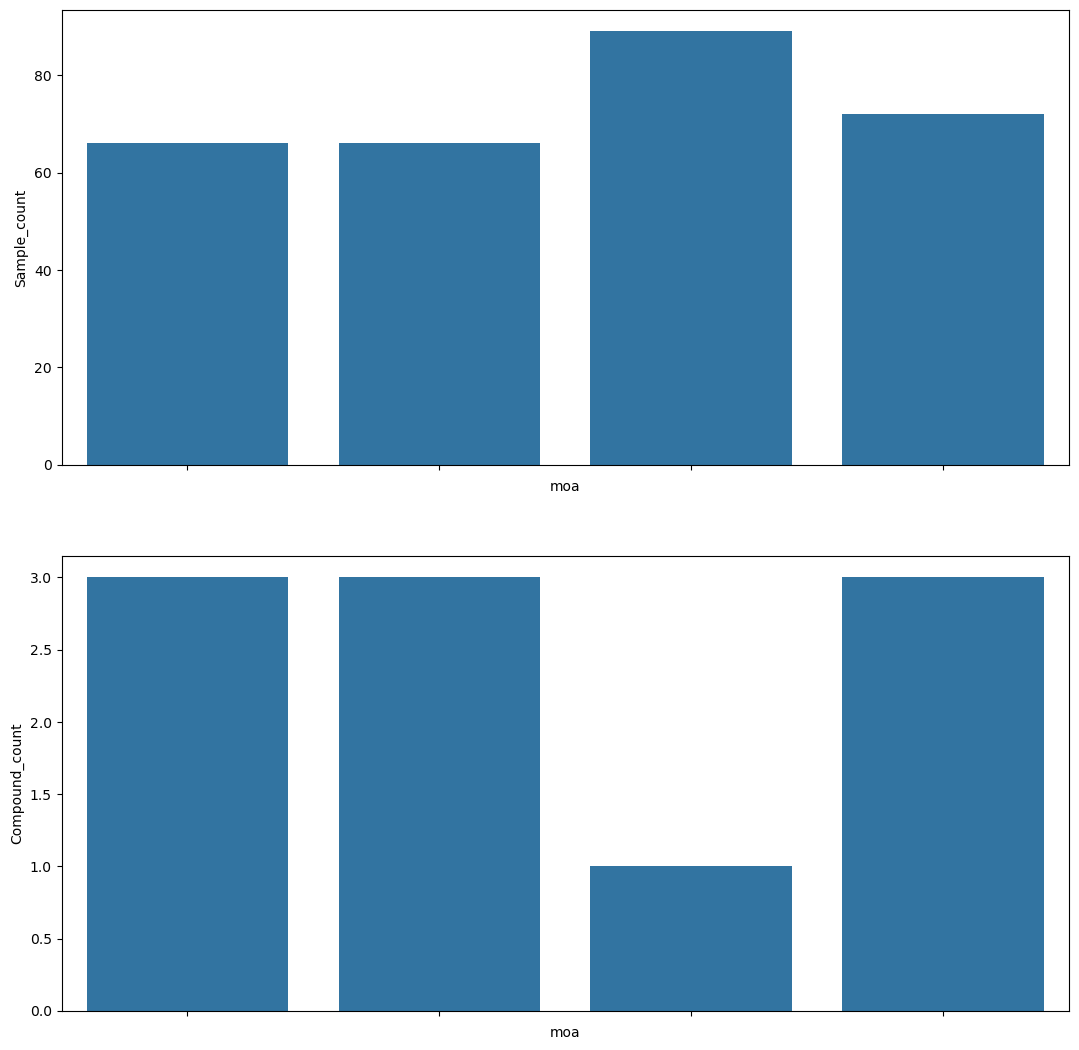

In [14]:
pdt.moa_distribution(pl.DataFrame(metadata_df_active_keep_dmso))

In [49]:
features_df_active_keep_dmso = pd.read_csv("target2_eq_moa2_features", index_col="ID")
features_df_active_keep_dmso = features_df_active_keep_dmso.loc[metadata_df_active_keep_dmso.ID]

In [58]:
metadata_df_active_keep_dmso = metadata_df_active_keep_dmso.reset_index(drop=True)
metadata_df_active_keep_dmso["ID"] = metadata_df_active_keep_dmso.index
features_df_active_keep_dmso.index = metadata_df_active_keep_dmso.index
features_df_active_keep_dmso.index.rename("ID", inplace=True)

In [61]:
# metadata_df_active_keep_dmso.to_csv("target2_eq_moa2_active_metadata")
# features_df_active_keep_dmso.to_csv("target2_eq_moa2_active_features")

In [25]:
# features_df_active_keep_dmso = features_drop_corr_gpu(threshold=0.95).fit_transform(features_df_active_keep_dmso)
# dmso_scaler = RobustScaler().fit(features_df_active_keep_dmso[metadata_df_active_keep_dmso["trt_dmso"] == "DMSO"])
# features_df_active_keep_dmso = dmso_scaler.transform(features_df_active_keep_dmso)

In [26]:
# mask = np.ones(len(metadata_df["Micro_id"])).astype(bool)# == 2
model_umap = umap.UMAP()
features_df_umap = model_umap.fit_transform(features_df_active_keep_dmso)

Text(0.5, 1.0, 'UMAP - InChIKey')

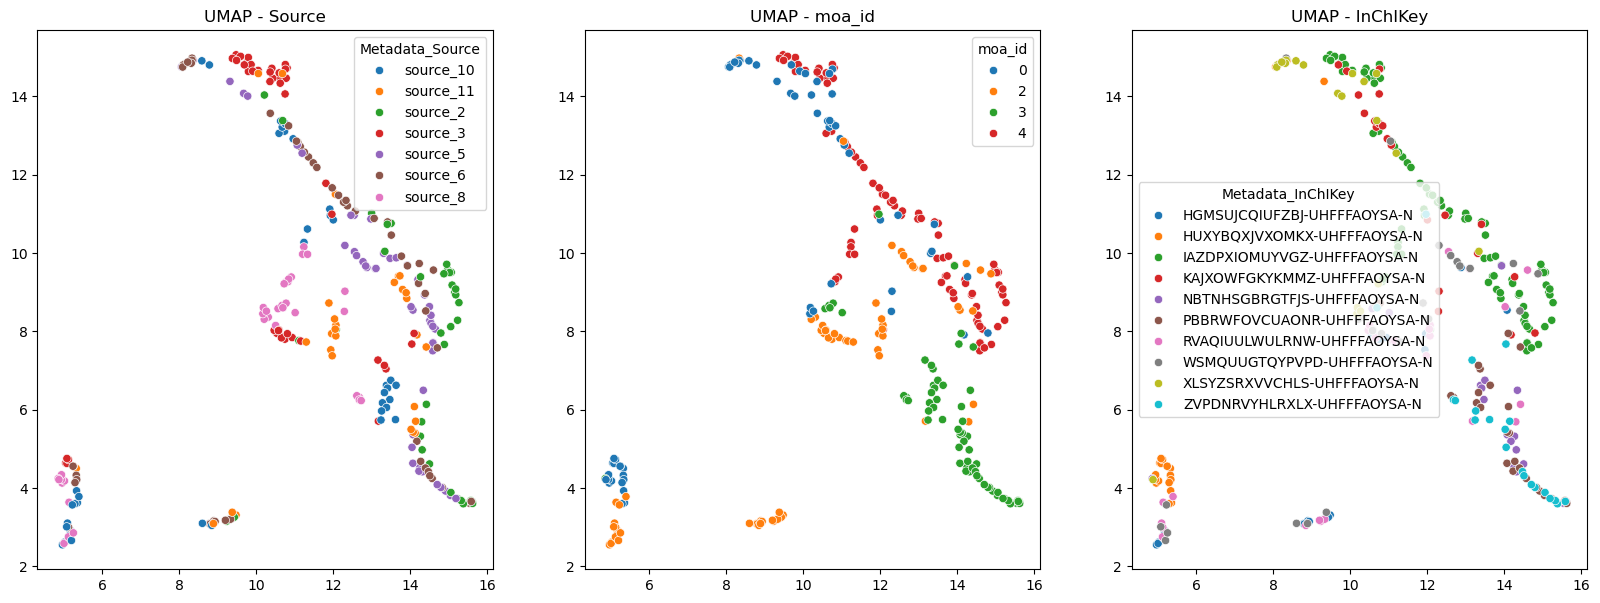

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes = axes.flatten()


sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df_active_keep_dmso["Metadata_Source"],#.str.slice(1).sort_values(),#.where(metadata_df_active_keep_dmso["moa_id"]==0, other="other"),
                ax=axes[0],
                palette="tab10")
axes[0].set_title("UMAP - Source")
#axes[0].get_legend().remove()

sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df_active_keep_dmso["moa_id"],
                ax=axes[1], 
                palette="tab10")
axes[1].set_title("UMAP - moa_id")

sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df_active_keep_dmso["Metadata_InChIKey"],
                #alpha=0.2,
                ax=axes[2], 
                palette="tab10")
axes[2].set_title("UMAP - InChIKey")

# 4) Check Consistency within MoA
This part is to further filter the dataset. Since we don't have much compound now, we are going to focus instead on the dataset retrieved and see how much our result has improved and then eventually work with this dataset. 

In [35]:
mask = metadata_df_active_keep_dmso["trt_dmso"] == "trt"

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

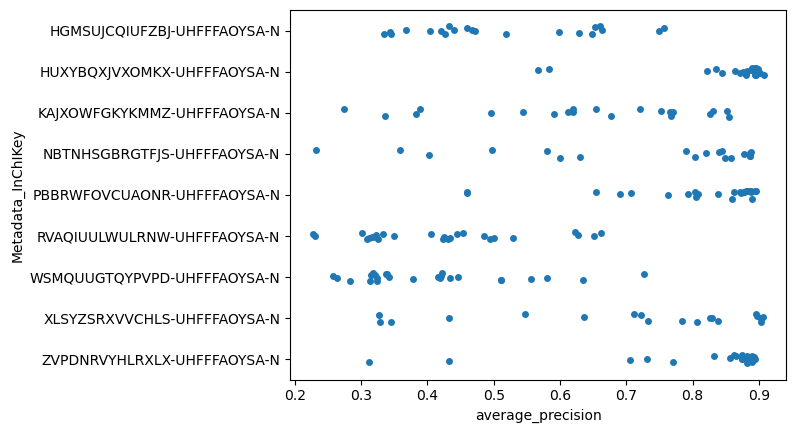

In [36]:
pos_sameby = ["moa_id"]  # We want to match perturbations
pos_diffby = ["ID"]#["Metadata_InChIKey"]
neg_sameby = []
neg_diffby = ["moa_id"]
batch_size = 20000


result = average_precision(
    metadata_df_active_keep_dmso[mask],
    features_df_active_keep_dmso[mask].to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)

sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")
result = result[result["trt_dmso"] != "DMSO"]

In [37]:
mAP = mean_average_precision(result, ["ID"], null_size=10000, threshold=0.05, seed=42)
mAP["-log10(p-value)"] = -mAP["corrected_p_value"].apply(np.log10)
mAP[mAP["below_corrected_p"] == True]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

,ID,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,-log10(p-value)
2,141,0.439546,0.030297,0.040931,True,True,1.387948
6,145,0.749241,0.000100,0.000156,True,True,3.807685
7,146,0.757721,0.000100,0.000156,True,True,3.807685
8,147,0.628669,0.000100,0.000156,True,True,3.807685
9,148,0.598556,0.000100,0.000156,True,True,3.807685
...,...,...,...,...,...,...,...
199,770,0.893357,0.000100,0.000156,True,True,3.807685
200,771,0.881627,0.000100,0.000156,True,True,3.807685
201,772,0.770646,0.000100,0.000156,True,True,3.807685
202,773,0.731329,0.000100,0.000156,True,True,3.807685


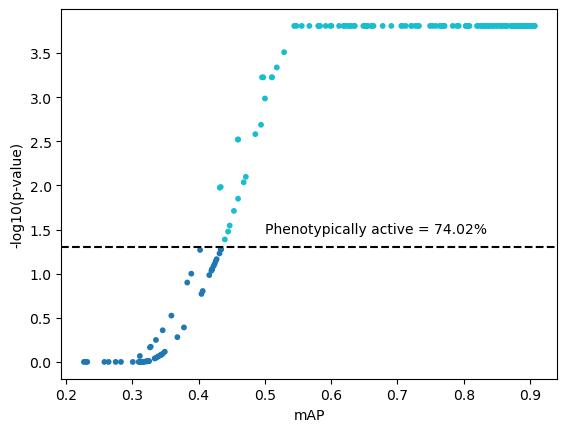

In [38]:
active_ratio = mAP.below_corrected_p.mean()

plt.scatter(data=mAP, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

In [41]:
mask_consistent = (metadata_df_active_keep_dmso["ID"].isin(mAP[mAP["below_corrected_p"]]["ID"]))

In [42]:
count_per_pert_moa = (pl.DataFrame(metadata_df_active_keep_dmso[mask][mask_consistent])
                      .group_by(["moa_id","Metadata_InChIKey"])
 .agg(pl.col("Metadata_InChIKey").count().alias("count_per_pert_moa"))
 .pivot(columns="moa_id",
       index="Metadata_InChIKey",
       values="count_per_pert_moa"))

/tmp/ipykernel_500022/1570749191.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count_per_pert_moa = (pl.DataFrame(metadata_df_active_keep_dmso[mask][mask_consistent])


In [47]:
count_per_pert_moa

Metadata_InChIKey,0,3,2
str,u32,u32,u32
"""KAJXOWFGKYKMMZ…",17,null,null
"""NBTNHSGBRGTFJS…",null,16,null
"""HUXYBQXJVXOMKX…",25,null,null
"""PBBRWFOVCUAONR…",null,26,null
"""RVAQIUULWULRNW…",null,null,10
"""ZVPDNRVYHLRXLX…",null,20,null
"""HGMSUJCQIUFZBJ…",null,null,13
"""WSMQUUGTQYPVPD…",null,null,7
"""XLSYZSRXVVCHLS…",17,null,null
